In [1]:
import pandas as pd
import rdkit
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch_geometric
import tqdm.notebook

In [2]:
zinc_table = pd.read_csv(
    "/gstore/home/tsenga5/discrete_graph_diffusion/data/250k_rndm_zinc_drugs_clean_3.csv",
    sep=",", header=0
)
zinc_table["smiles"] = zinc_table["smiles"].str.strip()
all_smiles = zinc_table["smiles"]

In [3]:
def smiles_to_networkx(smiles_string):
    mol = rdkit.Chem.MolFromSmiles(smiles_string)
    g = nx.Graph()
    for atom in mol.GetAtoms():
        g.add_node(
            atom.GetIdx(),
            atomic_num=atom.GetAtomicNum(),
            is_aromatic=atom.GetIsAromatic(),
            atom_symbol=atom.GetSymbol()
        )
    for bond in mol.GetBonds():
        g.add_edge(
            bond.GetBeginAtomIdx(),
            bond.GetEndAtomIdx(),
            bond_type=bond.GetBondType()
        )
    return g

In [4]:
ATOM_COLORS = {
    "C": "gray",
    "O": "lightcoral",
    "N": "royalblue"
}

def plot_molecule(mol_nx):
    atoms = nx.get_node_attributes(mol_nx, "atom_symbol")
    colors = []
    for node in mol_nx.nodes():
        try:
            colors.append(ATOM_COLORS[mol_nx.nodes[node]["atom_symbol"]])
        except KeyError:
            colors.append("violet")
    nx.draw(
        mol_nx,
        labels=atoms,
        with_labels=True,
        node_color=colors,
        node_size=500
    )
    plt.show()

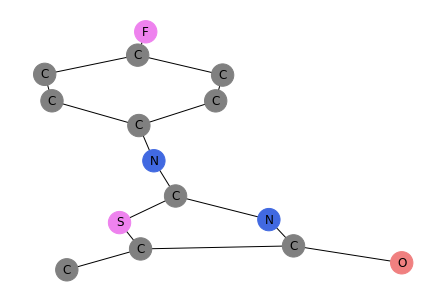

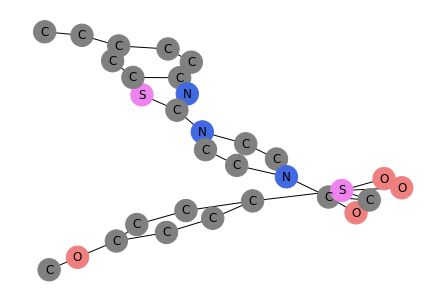

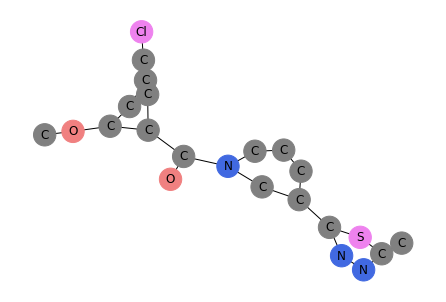

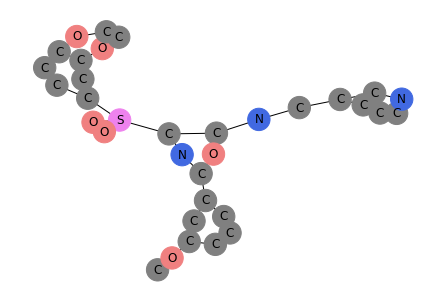

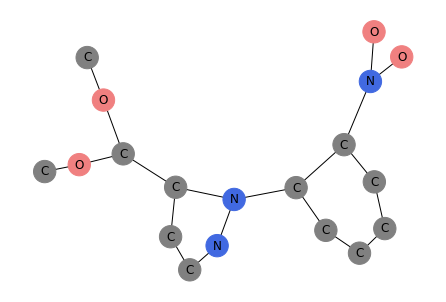

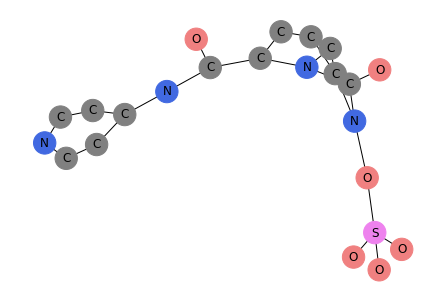

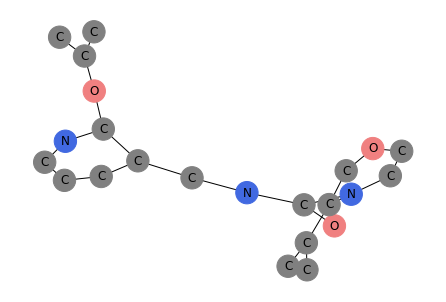

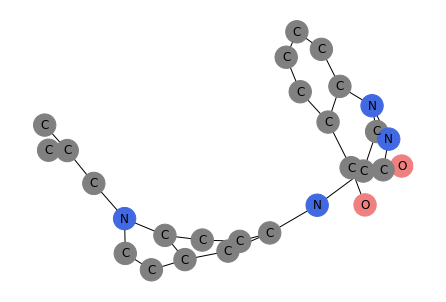

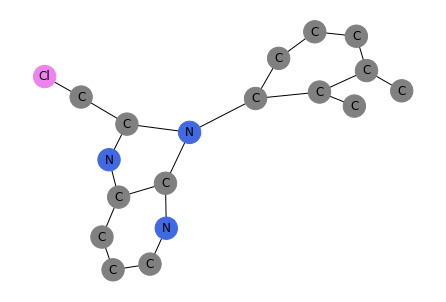

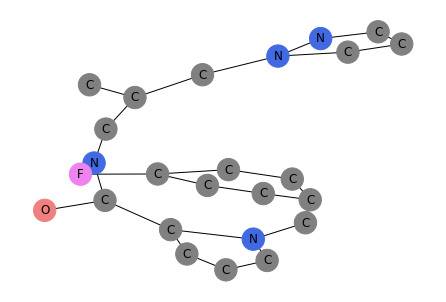

In [5]:
for s in np.random.choice(all_smiles, size=10, replace=False):
    plot_molecule(smiles_to_networkx(s))

In [6]:
num_with_only_single = 0
for s in tqdm.notebook.tqdm(all_smiles):
    g = smiles_to_networkx(s)
    only_single = True
    bond_types = np.unique([str(g.get_edge_data(*edge)["bond_type"]) for edge in g.edges()])
    if len(bond_types) == 1 and bond_types[0] == "SINGLE":
        num_with_only_single += 1
print("%d/%d (%.2f%%) only single bonds" % (num_with_only_single, len(all_smiles), num_with_only_single / len(all_smiles) * 100))

  0%|          | 0/249455 [00:00<?, ?it/s]

3401/249455 (1.36%) only single bonds


In [7]:
atoms, bonds = {}, {}
bond_type_dict = {}

for s in tqdm.notebook.tqdm(all_smiles):
    g = smiles_to_networkx(s)
    data = torch_geometric.utils.from_networkx(g)
    
    for a, c in zip(*np.unique(data.atom_symbol, return_counts=True)):
        try:
            atoms[a] += c
        except KeyError:
            atoms[a] = c
    
    new_bond_found = False
    for b, c in zip(*np.unique(data.bond_type.numpy(), return_counts=True)):
        try:
            bonds[b] += c
        except KeyError:
            bonds[b] = c
            new_bond_found = True
            
    if new_bond_found:
        edge_index, bond_type = data.edge_index.numpy(), data.bond_type.numpy()
        edge_index = np.transpose(edge_index)
        for bt in np.unique(bond_type):
            edge = edge_index[bond_type == bt][0]
            bond_type_dict[bt] = g.get_edge_data(edge[0], edge[1])["bond_type"]

  0%|          | 0/249455 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
for a in sorted(atoms.keys(), key=(lambda k: -atoms[k])):
    print("%s\t%d" % (a, atoms[a]))
print()
for b in sorted(bonds.keys(), key=(lambda k: -bonds[k])):
    print("%s\t%s\t%d" % (b, str(bond_type_dict[b]), bonds[b]))

C	4254871
N	705203
O	576231
S	102879
F	79430
Cl	42872
Br	12722
I	888
P	127

1	SINGLE	6417282
12	AROMATIC	5184126
2	DOUBLE	791386
3	TRIPLE	31174


In [9]:
def smiles_to_networkx(smiles):
    mol = rdkit.Chem.MolFromSmiles(smiles)
    g = nx.Graph()
    for atom in mol.GetAtoms():
        g.add_node(
            atom.GetIdx(),
            atomic_num=atom.GetAtomicNum()
        )
    for bond in mol.GetBonds():
        g.add_edge(
            bond.GetBeginAtomIdx(),
            bond.GetEndAtomIdx(),
            bond_type=bond.GetBondType()
        )
    return g


ATOM_MAP = torch.tensor([6, 7, 8, 9, 16, 17, 35, 53, 15])
BOND_MAP = torch.tensor([1, 2, 3, 12])

def smiles_to_pyg_data(smiles):
    """
    Converts a SMILES string to a torch-geometric Data object. The data
    object will have node attributes and edge attributes under `x` and
    `edge_attr`, respectively.
    Arguments:
        `smiles`: a SMILES string
    Returns a torch-geometric Data object.
    """
    g = smiles_to_networkx(smiles)
    data = torch_geometric.utils.from_networkx(g)
    data.edge_index = torch_geometric.utils.sort_edge_index(data.edge_index)
    
    # Set atom features
    atom_inds = torch.argmax((data.atomic_num.view(-1, 1) == ATOM_MAP).int(), dim=1)
    data.x = torch.nn.functional.one_hot(atom_inds, num_classes=len(ATOM_MAP))
    
    # Set bond features; for aromatic bonds, set them to be both single and double
    aromatic_mask = data.bond_type == BOND_MAP[-1]
    bond_inds = torch.argmax((data.bond_type.view(-1, 1) == BOND_MAP).int(), dim=1)
    bond_inds[aromatic_mask] = 0
    data.edge_attr = torch.nn.functional.one_hot(bond_inds, num_classes=(len(BOND_MAP) - 1))
    data.edge_attr[aromatic_mask, 1] = 1
    
    del data.atomic_num
    del data.bond_type
    
    return data

In [10]:
# Sanity checks
for s in tqdm.notebook.tqdm(np.random.choice(all_smiles, size=1000, replace=False)):
    g = smiles_to_networkx(s)
    data = smiles_to_pyg_data(s)

    assert len(data.x) == len(g)
    for i in range(len(g)):
        assert ATOM_MAP[data.x[i].argmax()].item() == g.nodes[i]["atomic_num"]
    assert len(data.edge_attr) == len(g.edges()) * 2

    bond_encodings = {
        "SINGLE": torch.tensor([1, 0, 0]),
        "DOUBLE": torch.tensor([0, 1, 0]),
        "TRIPLE": torch.tensor([0, 0, 1]),
        "AROMATIC": torch.tensor([1, 1, 0])
    }
    for i, j in g.edges():
        mask_1 = (data.edge_index[0] == i) & (data.edge_index[1] == j)
        assert torch.sum(mask_1) == 1
        mask_2 = (data.edge_index[0] == j) & (data.edge_index[1] == i)
        assert torch.sum(mask_2) == 1
        ind_1, ind_2 = torch.where(mask_1)[0][0], torch.where(mask_2)[0][0]
        assert torch.all(data.edge_attr[ind_1] == data.edge_attr[ind_2])
        assert torch.all(data.edge_attr[ind_1] == bond_encodings[str(g.get_edge_data(i, j)["bond_type"])])

  0%|          | 0/1000 [00:00<?, ?it/s]